In [27]:
import pandas as pd
import warnings
import re
import numpy as np

# NTLK functions
import nltk
from nltk.corpus import stopwords
from nltk import tokenize as tok
from nltk.stem.snowball import SnowballStemmer # load nltk's SnowballStemmer as variabled 'stemmer'
import string
from nltk.tag import StanfordNERTagger

warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tf-Idf and Clustering packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [28]:
review = pd.read_csv("review.csv")

In [29]:
data=review[['text']]

In [30]:
data["text"] = data["text"].str.lower()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [32]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0    party 6 hibachi. waitress brought separate sus...
1    yes, sushi place town. however, great you're c...
2    great burgers,fries salad! burgers hint salt p...
3    great addition funk zone! grab bite, grab tast...
4    bit weary trying shellfish company wharf often...
Name: text, dtype: object

In [33]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


204876    sorry person say good paid 41 7 chicken wing p...
204877    amazing dishes  great customer service probabl...
204878    could give 5 stars would reserved daisy 25 peo...
204879    ordered half rack pork ribs a la carte delicio...
204880    one favorite restaurants santa barbara reason ...
Name: text, dtype: object

In [34]:
data['text']

0         party 6 hibachi waitress brought separate sush...
1         yes sushi place town however great youre cravi...
2         great burgersfries salad burgers hint salt pep...
3         great addition funk zone grab bite grab tastin...
4         bit weary trying shellfish company wharf often...
                                ...                        
204876    sorry person say good paid 41 7 chicken wing p...
204877    amazing dishes  great customer service probabl...
204878    could give 5 stars would reserved daisy 25 peo...
204879    ordered half rack pork ribs a la carte delicio...
204880    one favorite restaurants santa barbara reason ...
Name: text, Length: 204881, dtype: object

In [35]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


204876    sorry person say good paid 1 7 chicken wing pi...
204877    amazing dishes  great customer service probabl...
204878    could give 5 stars would reserved daisy 25 peo...
204879    ordered half rack pork ribs a la carte delicio...
204880    one favorite restaurants santa barbara reason ...
Name: text, dtype: object

In [36]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


204876    sorry person say good paid 1 7 chicken wing pi...
204877    amazing dishes  great customer service probabl...
204878    could give 5 stars would reserved daisy 25 peo...
204879    ordered half rack pork ribs a la carte delicio...
204880    one favorite restaurants santa barbara reason ...
Name: text, dtype: object

In [37]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


204876    sorry person say good paid   chicken wing piec...
204877    amazing dishes  great customer service probabl...
204878    could give  stars would reserved daisy  people...
204879    ordered half rack pork ribs a la carte delicio...
204880    one favorite restaurants santa barbara reason ...
Name: text, dtype: object

In [38]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    [party, hibachi, waitress, brought, separate, ...
1    [yes, sushi, place, town, however, great, your...
2    [great, burgersfries, salad, burgers, hint, sa...
3    [great, addition, funk, zone, grab, bite, grab...
4    [bit, weary, trying, shellfish, company, wharf...
Name: text, dtype: object

In [40]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    [party, hibachi, waitress, brought, separate, ...
1    [yes, sushi, place, town, however, great, your...
2    [great, burgersfries, salad, burgers, hint, sa...
3    [great, addition, funk, zone, grab, bite, grab...
4    [bit, weary, trying, shellfish, company, wharf...
Name: text, dtype: object

In [41]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0    [party, hibachi, waitress, brought, separate, ...
1    [yes, sushi, place, town, however, great, your...
2    [great, burgersfries, salad, burgers, hint, sa...
3    [great, addition, funk, zone, grab, bite, grab...
4    [bit, weary, trying, shellfish, company, wharf...
Name: text, dtype: object

In [60]:
data_1 = data.text

In [66]:
data_1 = data_1.str.join(" ")

In [70]:
data_1 = data_1.str.cat(sep=' ')

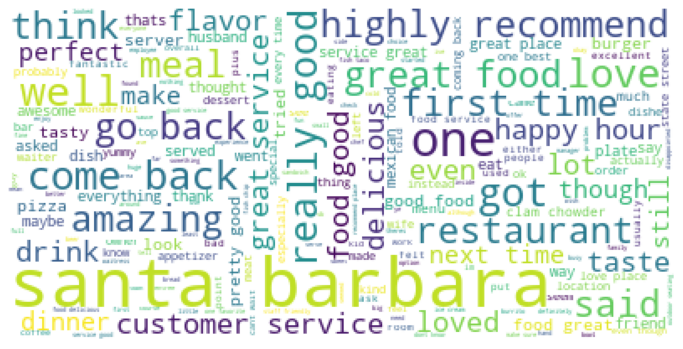

In [71]:
wordcloud = WordCloud(background_color="white").generate(data_1)

#plot the wordcloud
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show()

In [77]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

In [78]:
tokens = word_tokenize(data_1)

In [79]:
fdist = FreqDist(tokens)

In [101]:
fdist["china"]

378

In [91]:
fdist.most_common()

[('but', 154006),
 ('food', 140763),
 ('not', 111329),
 ('good', 111058),
 ('place', 102911),
 ('great', 96558),
 ('service', 77808),
 ('like', 57445),
 ('one', 53930),
 ('back', 53056),
 ('time', 52020),
 ('really', 49664),
 ('get', 48794),
 ('its', 48248),
 ('would', 46577),
 ('delicious', 45295),
 ('go', 44494),
 ('us', 42447),
 ('ordered', 42072),
 ('also', 41548),
 ('restaurant', 41402),
 ('best', 40197),
 ('got', 37438),
 ('order', 36995),
 ('nice', 36372),
 ('santa', 36268),
 ('it', 35732),
 ('barbara', 33901),
 ('no', 33574),
 ('amazing', 32985),
 ('came', 32884),
 ('well', 32287),
 ('love', 31038),
 ('chicken', 30385),
 ('definitely', 30074),
 ('menu', 30056),
 ('dont', 29760),
 ('even', 29732),
 ('fresh', 29489),
 ('staff', 29488),
 ('friendly', 28978),
 ('im', 28294),
 ('little', 27942),
 ('try', 27711),
 ('ive', 27478),
 ('come', 27345),
 ('always', 26348),
 ('didnt', 24603),
 ('salad', 23874),
 ('made', 23064),
 ('first', 22339),
 ('much', 22331),
 ('pretty', 22248),
 ('wa

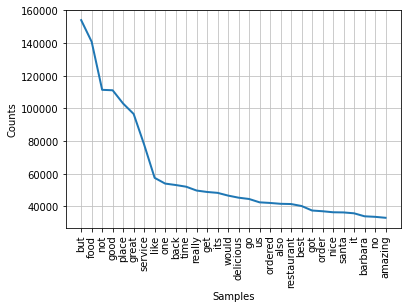

In [88]:
fdist.plot(30)
plt.show()

In [89]:
data["text"]

0         [party, hibachi, waitress, brought, separate, ...
1         [yes, sushi, place, town, however, great, your...
2         [great, burgersfries, salad, burgers, hint, sa...
3         [great, addition, funk, zone, grab, bite, grab...
4         [bit, weary, trying, shellfish, company, wharf...
                                ...                        
204876    [sorry, person, say, good, paid, chicken, wing...
204877    [amazing, dishes, great, customer, service, pr...
204878    [could, give, stars, would, reserved, daisy, p...
204879    [ordered, half, rack, pork, ribs, a, la, carte...
204880    [one, favorite, restaurants, santa, barbara, r...
Name: text, Length: 204881, dtype: object

In [102]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [104]:
data['polarity'] = data['text'].str.join(" ").apply(lambda x: analyzer.polarity_scores(x))

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [105]:
data

,text,polarity
0,"[party, hibachi, waitress, brought, separate, ...","{'neg': 0.022, 'neu': 0.579, 'pos': 0.399, 'co..."
1,"[yes, sushi, place, town, however, great, your...","{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou..."
2,"[great, burgersfries, salad, burgers, hint, sa...","{'neg': 0.0, 'neu': 0.644, 'pos': 0.356, 'comp..."
3,"[great, addition, funk, zone, grab, bite, grab...","{'neg': 0.0, 'neu': 0.613, 'pos': 0.387, 'comp..."
4,"[bit, weary, trying, shellfish, company, wharf...","{'neg': 0.014, 'neu': 0.663, 'pos': 0.323, 'co..."
...,...,...
204876,"[sorry, person, say, good, paid, chicken, wing...","{'neg': 0.039, 'neu': 0.788, 'pos': 0.173, 'co..."
204877,"[amazing, dishes, great, customer, service, pr...","{'neg': 0.0, 'neu': 0.335, 'pos': 0.665, 'comp..."
204878,"[could, give, stars, would, reserved, daisy, p...","{'neg': 0.012, 'neu': 0.515, 'pos': 0.473, 'co..."
204879,"[ordered, half, rack, pork, ribs, a, la, carte...","{'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp..."


In [107]:
# Change data structure
df = pd.concat(
    [data.drop(['polarity'], axis=1), 
     data['polarity'].apply(pd.Series)], axis=1)
df.head(3)

,text,neg,neu,pos,compound
0,"[party, hibachi, waitress, brought, separate, ...",0.022,0.579,0.399,0.9857
1,"[yes, sushi, place, town, however, great, your...",0.000,0.620,0.380,0.9607
2,"[great, burgersfries, salad, burgers, hint, sa...",0.000,0.644,0.356,0.8555


In [108]:
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df.head(4)

,text,neg,neu,pos,compound,sentiment
0,"[party, hibachi, waitress, brought, separate, ...",0.022,0.579,0.399,0.9857,positive
1,"[yes, sushi, place, town, however, great, your...",0.000,0.620,0.380,0.9607,positive
2,"[great, burgersfries, salad, burgers, hint, sa...",0.000,0.644,0.356,0.8555,positive
3,"[great, addition, funk, zone, grab, bite, grab...",0.000,0.613,0.387,0.9118,positive


In [110]:
import seaborn as sns

/Users/eason/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


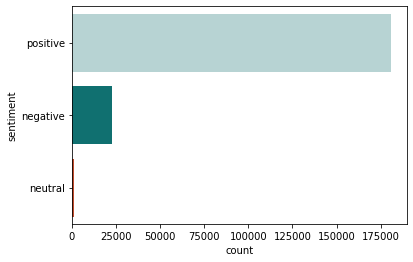

In [111]:
sns.countplot(y='sentiment', 
             data=df, 
             palette=['#b2d8d8',"#008080", '#db3d13']
             );

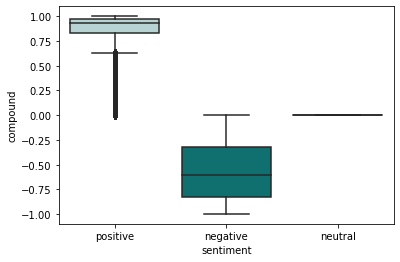

In [113]:
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=df);

In [124]:
review.iloc[df[df.sentiment =="negative"].index].business_id.unique()

array(['Wy8Hswf2cLQGRZN6armkag', '18eWJFJbXyR9j_5xfcRLYA',
       '29YqJwOGEuAWqlHZxMc1OA', 'bjhCtlYHrkgA5Ku8l-rB3g',
       '6kPHr6gZaU9732ptn9gJrA', 'O6RCCmz8-x4NhWJpI8KQug',
       'gebiRewfieSdtt17PTW6Zg', '34Eqv8jXgxg_EEwcsNgeeg',
       'XwnkfMUiyH-OsJXbmbOK5g', 'jW4a3W9-UkFxpglHvo_Kqg',
       'LswO4EWgN99h6NEEJ7qtCA', 'sNyHfboSOs-ESN76cYFfTA',
       '7IdIGemGZodDAA_9mJCigA', 'VeFfrEZ4iWaecrQg6Eq4cg',
       'uO39--k_hrCFgZh-Bl8m8A', 'ju4YP8SLdR_BmWr_-Xh83Q',
       'SZU9c8V2GuREDN5KgyHFJw', 'q6661I3CGW0UB740E5Zjfw',
       'HQ-C47_Xi5it1KzwEc0u0A', '-3AooxIkg38UyUdlz5oXdw',
       'xwSWtJcQkzTF6HNm_IMgcg', 'uFF40n9pOqHK1ciajdoSEw',
       '0qu0fNTOsSmuREYVIMPuIQ', 'DzpaiMQnB_sNhZPrgdvKHg',
       'S3QHy1sshUeZwXOYviVsXQ', 'T2otvNcawDSkhykOG2tOLA',
       'lTVHJAvtFQbQb6cPstEXyA', 'bbEXAEFr4RYHLlZ-HFssTA',
       'uI15YInpDsGBUZcNfm_TfQ', 'CYwC5OjwCN6ib_AQDxi3Ow',
       'bdfZdB2MTXlT6-RBjSIpQg', 'vC2qm1y3Au5czBtbhc-DNw',
       'ygZyTUWS4dbVL8d6vAiN4A', 'It1sdsL61jZxbHd63gjdHA

In [128]:
df[df.sentiment =="negative"]

,text,neg,neu,pos,compound,sentiment
5,"[could, give, zero, would, order, plain, hambu...",0.149,0.749,0.102,-0.5903,negative
7,"[first, time, tried, place, surprisingly, surp...",0.120,0.731,0.149,-0.1103,negative
8,"[disappointing, many, levels, coming, years, q...",0.217,0.607,0.177,-0.2730,negative
10,"[disappointed, went, eat, saturday, told, kitc...",0.140,0.794,0.066,-0.4215,negative
15,"[new, owners, turned, double, threat, bad, foo...",0.553,0.287,0.160,-0.8625,negative
...,...,...,...,...,...,...
204860,"[pros, location, miles, several, downtown, sho...",0.115,0.798,0.086,-0.5106,negative
204861,"[well, going, place, breakfast, months, straig...",0.163,0.721,0.115,-0.5152,negative
204865,"[stars, value, ravioli, bucatini, amatriciana,...",0.118,0.770,0.112,-0.1426,negative
204870,"[let, begin, stating, owner, naan, stop, compl...",0.200,0.626,0.174,-0.6990,negative
